<a href="https://colab.research.google.com/github/Aduomas/aviation_consequences/blob/main/Aviation_Consequences_Prediction_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting the consequences of aviation accidents using NNs.

## Methodology

- Importing Libraries
- Downloading Dataset
- Dataset Preprocessing
  - NaN Removal
  - Transforming Strings to lower case letters only
  - Data Encoding (**OneHotEncoder**)
  - Data Normalization (**MinMaxScaler**)
- Train Test Split (80/20 Data Split) - both sets containing same ratio of FATAL to NOT FATALS.
- Machine Learning
  - Initializing Sequential Keras (Tensorflow) Neural Network Model
    - 1st Layer (Input Layer) - 65 Inputs
    - 2nd Layer (Hidden Layer 1) - 20 Neurons
    - 3rd Layer (Hidden Layer 2) - 30 Neurons
    - 4th Layer (Hidden Layer 3) - 30 Neurons
    - 5th Layer (Hidden Layer 4) - 20 Neurons
    - 6th Layer (Output Layer) - 1 Output
  - Compiling the model using **0.0001** learning rate, **Adam** Optimizer, **binary_crossentropy** loss function.
  - Training The Model
    - Splitting the train data in batches of 16 data points.
    - Predicting outputs based on the batch of data (16 data points).
    - Calculating loss using **binary_crossentropy** loss function (https://androidkt.com/choose-cross-entropy-loss-function-in-keras/)
    - Backpropagation Algorithm for changing Neuron weights across layers (very hard to understand) (https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9)
    - Repeating until no batches left
    - Repeating until n-amount of epochs.
  - Evaluating model using Test Set Predictions against Actual Values
    - Accuracy
    - Confusion Matrix
    - binary_crossentropy loss
  - Evluating feature importance using SHAP
    

## Importing Libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')

## Importing dataset

In [1]:
!gdown --id 1pF1VFVXc8GpXWFSAML5impQLvCwON4k4

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pF1VFVXc8GpXWFSAML5impQLvCwON4k4
To: /content/data.xlsx
100% 123k/123k [00:00<00:00, 2.90MB/s]


In [3]:
df = pd.read_excel('data.xlsx')
df.head(2)

,ye,FROM,TO,FLIGHT PHASE,IMC/VMC,CAUSE,HUMAN FACTOR,DATE,PAX/CARGO,DAY/NIGHT,...,Authority Gradient,Distraction,Stress,Malicious Interference,status awareness,Pre Flight Data Input Error,Flight / Cabin Crew Co-operation,Pressure altimeter setting error,Pilot Startle Response,Flight Crew / Ground Crew Co-operation
0,Airbus A300-600,NaN,NaN,Approach,VMC,"Inadequate Maintenance Schedule, Component Fau...","skills deficiency, Manual Handling, Ineffectiv...",2011 01-10,CARGO,NIGHT,...,NO Authority Gradient,NO Distraction,NO Stress,NO Malicious Interference,NO status awareness,NO Pre Flight Data Input Error,NO Flight / Cabin Crew Co-operation,NO Pressure altimeter setting error,NO Pilot Startle Response,NO Flight Crew / Ground Crew Co-operation
1,Airbus A300-600,NaN,NaN,Descent,IMC,"Approach not stabilised, Non Precision Approac...","Fatigue, Procedural non compliance, Ineffectiv...",14/08/2013,CARGO,NIGHT,...,NO Authority Gradient,NO Distraction,NO Stress,NO Malicious Interference,NO status awareness,NO Pre Flight Data Input Error,NO Flight / Cabin Crew Co-operation,NO Pressure altimeter setting error,NO Pilot Startle Response,NO Flight Crew / Ground Crew Co-operation


### Data Inspection

Checking all the columns within the dataset.

In [5]:
df.columns

Index(['ye', 'FROM', 'TO', 'FLIGHT PHASE', 'IMC/VMC', 'CAUSE', 'HUMAN FACTOR',
       'DATE', 'PAX/CARGO', 'DAY/NIGHT', 'FATAL/NOTFATAL', 'AIRCRAFT DAMAGE',
       'WEATHER INFO', 'Column1', 'Unnamed: 14', 'LANDING ', 'Unnamed: 16',
       'skills deficiency', 'manual Handling', ' Ineffective Monitoring ',
       'Fatigue', 'Procedural non compliance', 'Pilot Medical Fitness',
       'Violation', 'Data use error', 'Inappropriate ATC Communication',
       ' innapropiate crew response ', 'Plan Continuation Bias',
       'Dual Sidestick Input', 'spatial Disorientation', 'Authority Gradient',
       'Distraction', 'Stress', 'Malicious Interference', 'status awareness',
       'Pre Flight Data Input Error', 'Flight / Cabin Crew Co-operation',
       'Pressure altimeter setting error', 'Pilot Startle Response',
       'Flight Crew / Ground Crew Co-operation'],
      dtype='object')

Quite a lot of columns, let's check types of data and counts.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ye                                      129 non-null    object 
 1   FROM                                    0 non-null      float64
 2   TO                                      0 non-null      float64
 3   FLIGHT PHASE                            128 non-null    object 
 4   IMC/VMC                                 127 non-null    object 
 5   CAUSE                                   127 non-null    object 
 6   HUMAN FACTOR                            128 non-null    object 
 7   DATE                                    128 non-null    object 
 8   PAX/CARGO                               127 non-null    object 
 9   DAY/NIGHT                               127 non-null    object 
 10  FATAL/NOTFATAL                          128 non-null    object

Let's drop columns with nans and check the amount of unique values in each of the columns.

In [7]:
df = df.drop(columns=['FROM', 'TO', 'WEATHER INFO', 'Unnamed: 14', 'Column1', 'LANDING ', 'Unnamed: 16'])

In [8]:
for column in df:
  print("Column: {0:40} Unique Values {1}".format(column, df[column].nunique()))

Column: ye                                       Unique Values 85
Column: FLIGHT PHASE                             Unique Values 13
Column: IMC/VMC                                  Unique Values 3
Column: CAUSE                                    Unique Values 109
Column: HUMAN FACTOR                             Unique Values 112
Column: DATE                                     Unique Values 121
Column: PAX/CARGO                                Unique Values 7
Column: DAY/NIGHT                                Unique Values 7
Column: FATAL/NOTFATAL                           Unique Values 25
Column: AIRCRAFT DAMAGE                          Unique Values 12
Column: skills deficiency                        Unique Values 2
Column: manual Handling                          Unique Values 2
Column:  Ineffective Monitoring                  Unique Values 2
Column: Fatigue                                  Unique Values 2
Column: Procedural non compliance                Unique Values 2
Column: Pilot M

Most of the columns are binary which will be easily dealt with. However, some of the columns include a lot of unique values, let's check these.

### Columns that require preprocessing

Transforming strings to lower case only.

In [9]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

### Feature Engineering

These columns below would require embedding and extensive preprocessing to be efficient. There is no time to do that here.

### Functions for use

In [10]:
def unique_values_in_list_series(series, return_len=True):
  value_list = []
  for i, v in series.items():
    if isinstance(v, list):
      value_list.extend(v)
  value_set = set(value_list)
  if return_len:
    return len(list(value_set))
  return list(value_set)

### CAUSE Column

In [11]:
df['CAUSE'].sample(5)

93                        event reporting non compliant
76    approach not stabilised, non precision approac...
28    event reporting non compliant, inadequate atc ...
74    approach not stabilised, event reporting non c...
26                              approach not stabilised
Name: CAUSE, dtype: object

In [12]:
unique_values_in_list_series(df['CAUSE'].str.split(','))

88

Over 88 unique values, given that there are 125 rows of data, it would bring little to no benefits for using the column, however it might be possible to cluster the possible data points.

### HUMAN FACTOR Column

In [13]:
df['HUMAN FACTOR'].sample(5)

67    ineffective monitoring, ineffective monitoring...
75    ineffective monitoring, manual handling, plan ...
93    ineffective monitoring, procedural non compliance
46    ineffective monitoring, procedural non compliance
4     data use error, ineffective monitoring, proced...
Name: HUMAN FACTOR, dtype: object

In [14]:
unique_values_in_list_series(df['HUMAN FACTOR'].str.split(','))

56

In [15]:
unique_values_in_list_series(df['HUMAN FACTOR'].str.split(','), return_len=False)

['ineffective monitoring',
 ' ifr flight plan',
 ' inappropriate crew response (technical fault)',
 ' ineffective monitoring - pic as pf',
 ' fatigue',
 'neffective monitoring',
 'flight crew / ground crew co-operation',
 'pilot medical fitness',
 ' pilot startle response',
 ' plan continuation bias',
 'nappropriate crew response - skills deficiency',
 'manual handling',
 ' stress',
 ' ineffective monitoring - sic as pf',
 ' inappropriate crew response (automatics)',
 ' ineffective monitoring',
 ' ineffective monitoring ',
 'data use error',
 ' procedural non compliance',
 'fatigue',
 'nappropriate crew response (automatics)',
 'no',
 ' spatial disorientation',
 ' inappropriate crew response - skills deficiency',
 'spatial disorientation',
 'the inputs to the auto flight systems by the crew member believed to be the captain who remained alone in the cockpit when the person believed to be the co-pilot requested to go to the lavatory (which) caused the aircraft to depart from cruise flig

### DATE Column

In [16]:
df['DATE'].sample(5)

112    21/01/2010
1      14/08/2013
0      2011 01-10
122    11/01/1995
5      31/03/2003
Name: DATE, dtype: object

In [17]:
df = df.drop(index=[0, 128])

In [18]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df = df.drop(columns=['DATE'])

### DAY/NIGHT Column

In [19]:
df['DAY/NIGHT'] = df['DAY/NIGHT'].str.strip()

In [20]:
df['DAY/NIGHT'].value_counts()

day      75
night    51
Name: DAY/NIGHT, dtype: int64

### FATAL/NOTFATAL Column

In [21]:
def fatal_column(value):
  if value == "no":
    return 0
  if value == "none":
    return 0
  else:
    return 1

In [22]:
df['FATAL/NOTFATAL'] = df.apply(lambda x: fatal_column(x['FATAL/NOTFATAL']), axis=1)

### AIRCRAFT DAMAGE Column

In [23]:
df['AIRCRAFT DAMAGE'] = df['AIRCRAFT DAMAGE'].str.strip()

In [24]:
def aircraft_dmg_column(value):
  if value == "no":
    return 0
  else:
    return 1

In [25]:
df['AIRCRAFT DAMAGE'] = df.apply(lambda x: aircraft_dmg_column(x['AIRCRAFT DAMAGE']), axis=1)

In [26]:
df.dropna(inplace=True)

### ye Column

Let's check manufacturers.

In [27]:
df['ye'].value_counts()[:20]

boeing 737-800         16
airbus a320             6
a320                    5
airbus a300-600         3
a330                    3
a321                    3
a340                    2
boeing 737-400          2
dassault falcon 20      2
dhc8-400                2
boeing 777-300          2
boeing 757-200          2
boeing 747-400f         2
cessna 550              2
dornier 328             2
boeing 737-300          2
atr 42-300              2
dhc-6-300               1
bombardier dhc8-100     1
boeing 787-10           1
Name: ye, dtype: int64

In [28]:
def manufacturer_apply(value):
  if "boeing" in value:
    return "boeing"
  re_search = re.search('a\d{3}', value)
  if "airbus" in value:
    return "airbus"
  if re_search:
    if len(re_search.string) > 2:
      return "airbus"
  
  if value.split():
    if len(value.split()) > 1:
      return value.split()[0]
  
  return "other"

In [29]:
import re

In [30]:
df['ye'] = df.apply(lambda x: manufacturer_apply(x['ye']), axis=1)

## Feature Engineering 

### Clustering (test)

#### Imports

In [31]:
pip install fuzzywuzzy plotly gensim webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

#Load data set
human_factor_text = df['HUMAN FACTOR']
causes_text = df['CAUSE']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Stopwords Removal

In [33]:
#Remove stopwords, punctuation and numbers
causes_text = [remove_stopwords(x.encode())\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        if x and isinstance(x, str) else "" for x in causes_text]

In [34]:
#Remove stopwords, punctuation and numbers
human_factor_text = [remove_stopwords(x.encode())\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        if x and isinstance(x, str) else "" for x in human_factor_text]

#### Stemming

In [35]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text_cause = pd.Series([stemSentence(x) for x in causes_text])
text_human = pd.Series([stemSentence(x) for x in human_factor_text])

#### Vectorization

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
cause_cards = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(text_cause)]

human_cards = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(text_human)]

In [37]:
# model = Doc2Vec(vector_size=64, min_count=1, epochs = 20)
#instantiate model
model_cause = Doc2Vec(vector_size=16, window=2, min_count=1, workers=8, epochs = 40)
model_human = Doc2Vec(vector_size=16, window=2, min_count=1, workers=8, epochs = 40)

#build vocab
model_cause.build_vocab(cause_cards)
model_human.build_vocab(human_cards)
#train model
model_cause.train(cause_cards, total_examples=model_cause.corpus_count
            , epochs=model_cause.epochs)
model_human.train(human_cards, total_examples=model_human.corpus_count
            , epochs=model_human.epochs)

In [38]:
cause2vec = [model_cause.infer_vector((text_cause[i].split(' '))) 
            for i in range(0,len(text_cause))]

human2vec = [model_human.infer_vector((text_human[i].split(' '))) 
            for i in range(0,len(text_human))]

In [39]:
kmeans_cause = KMeans(n_clusters=5, random_state=0).fit(cause2vec)
kmeans_human = KMeans(n_clusters=2, random_state=0).fit(human2vec)

In [40]:
df['CAUSE_cluster'] = kmeans_cause.labels_
df['HUMAN FACTOR_cluster'] = kmeans_human.labels_

In [41]:
df.drop(columns=['CAUSE', 'HUMAN FACTOR'], inplace=True)

### Feature Meaning



 - 0   ye                                      127 non-null    object - MODEL
 - 1   FLIGHT PHASE                            127 non-null    object - PHASE
 - 2   IMC/VMC                                 126 non-null    object - +
 - 3   PAX/CARGO                               126 non-null    object - +
 - 4   DAY/NIGHT                               126 non-null    object - +
 - 5   FATAL/NOTFATAL                          127 non-null    int64  - NO
 - 6   AIRCRAFT DAMAGE                         127 non-null    int64  - NO
 - 7   skills deficiency                       127 non-null    object - ?
 - 8   manual Handling                         127 non-null    object - ?
 - 9    Ineffective Monitoring                 127 non-null    object - ?
 - 10  Fatigue                                 127 non-null    object - 
 - 11  Procedural non compliance               127 non-null    object
 - 12  Pilot Medical Fitness                   127 non-null    object
 - 13  Violation                               127 non-null    object
 - 14  Data use error                          127 non-null    object
 - 15  Inappropriate ATC Communication         127 non-null    object
 - 16   innapropiate crew response             127 non-null    object
 - 17  Plan Continuation Bias                  127 non-null    object
 - 18  Dual Sidestick Input                    127 non-null    object
 - 19  spatial Disorientation                  127 non-null    object
 - 20  Authority Gradient                      127 non-null    object
 - 21  Distraction                             127 non-null    object
 - 22  Stress                                  127 non-null    object
 - 23  Malicious Interference                  127 non-null    object
 - 24  status awareness                        127 non-null    object
 - 25  Pre Flight Data Input Error             127 non-null    object
 - 26  Flight / Cabin Crew Co-operation        127 non-null    object
 - 27  Pressure altimeter setting error        127 non-null    object
 - 28  Pilot Startle Response                  127 non-null    object
 - 29  Flight Crew / Ground Crew Co-operation  127 non-null    object
 - 30  YEAR                                    127 non-null    int64 
 - 31  MONTH                                   127 non-null    int64 
 - 32  DAY                                     127 non-null    int64 



## Train Test Split

In [42]:
X = df.drop(columns=['FATAL/NOTFATAL'])
y = df[['FATAL/NOTFATAL']]

X = pd.get_dummies(X, drop_first=True)

Splitting data.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Encoding

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

### OneHotEncoder

... done

### Normalization

In [48]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Machine Learning

In [49]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Logistic Regression

In [50]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

# clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)
clf = LogisticRegression().fit(X_train, y_train)

In [51]:
clf.score(X_test, y_test)

0.76

80% accuracy for logistic regresison - really good

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

# multilabel_confusion_matrix(y_test, clf.predict(X_test))
confusion_matrix(y_test, clf.predict(X_test))

array([[ 3,  5],
       [ 1, 16]])

A lot of false positives.

In [53]:
from sklearn.metrics import roc_auc_score

# y_pred = clf.predict_proba(X_test)
# y_pred = np.transpose([pred[:, 1] for pred in y_pred])
# roc_auc_score(y_test, y_pred, average=None)

roc_auc_score(y_test, clf.decision_function(X_test))

0.9191176470588236

93% AREA UNDER THE CURVE

### NN

In [54]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(units=20, activation="relu", input_shape=(X_train.shape[-1],) ),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=30, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=30, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=20, activation="relu"),
        # the output layer, with a single neuron
        # keras.layers.Dense(units=2, activation="sigmoid"),
        keras.layers.Dense(units=1, activation="sigmoid"),
     
    ]
)

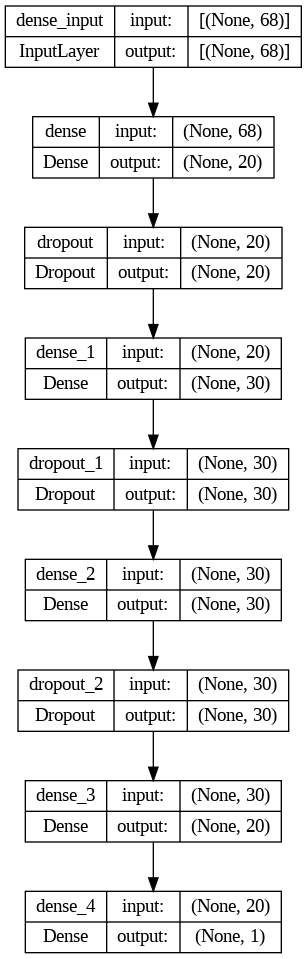

In [55]:
keras.utils.plot_model(model, show_shapes=True)

In [56]:
learning_rate = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              # metrics=keras.metrics.AUC()
              # metrics=[f1_m]
              metrics=['accuracy']
             )

In [57]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0  8]
 [ 1 17]]


In [58]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 47]
 [ 1 76]]


In [59]:
total = 47 + 76

weight_for_0 = (1 / 47) * (total / 2.0)
weight_for_1 = (1 / 76) * (total / 2.0)

In [60]:
class_weight = {0: weight_for_0, 1: weight_for_1}

In [61]:
class_weight

{0: 1.3085106382978724, 1: 0.8092105263157894}

### Skip

In [ ]:
history = model.fit(X_train, y_train, 
          epochs=50, 
          validation_data=(X_test, y_test),
          verbose=0,
          class_weight=class_weight)

KeyError: ignored

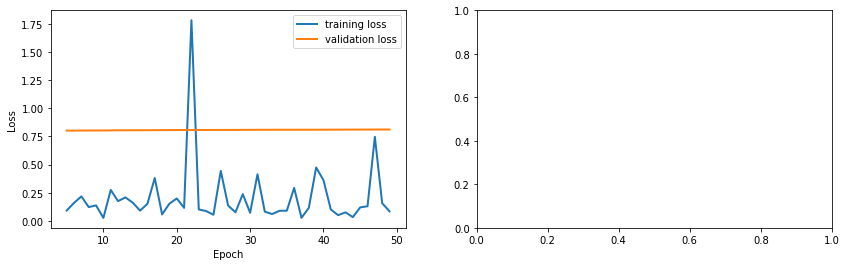

In [ ]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc_2"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc_2"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

### Continue

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0002, # minimium amount of change to count as an improvement
    patience  = 30,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [63]:
history = model.fit(X_train, y_train, 
          epochs=100,
          batch_size=16, 
          validation_data=(X_test, y_test),
          verbose=0,
          # add in our early stopping callback
          callbacks=[early_stopping],
          class_weight=class_weight,
        )

In [64]:
logs = pd.DataFrame(history.history)
logs

,loss,accuracy,val_loss,val_accuracy
0,0.717632,0.551020,0.663756,0.72
1,0.724648,0.479592,0.663432,0.72
2,0.693767,0.612245,0.662609,0.72
3,0.723232,0.489796,0.662736,0.76
4,0.702504,0.571429,0.663528,0.76
5,0.734571,0.448980,0.663857,0.76
6,0.687685,0.591837,0.664995,0.76
7,0.695599,0.602041,0.666568,0.76
8,0.715290,0.530612,0.666879,0.72
9,0.693877,0.591837,0.667011,0.72


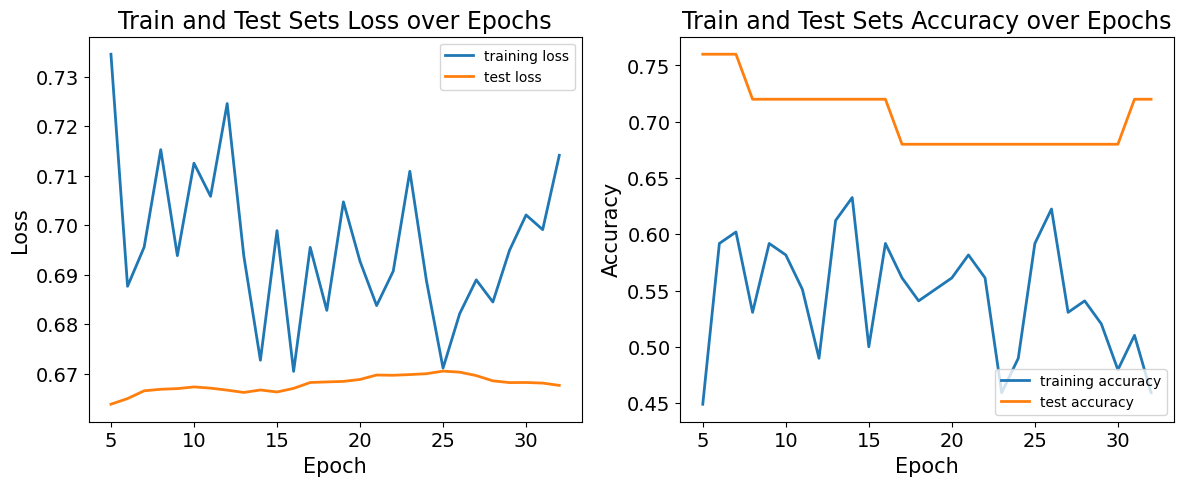

In [65]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("Train and Test Sets Loss over Epochs", fontsize=17)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='test loss')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Train and Test Sets Accuracy over Epochs", fontsize=17)
plt.plot(logs.loc[5:, logs.columns[1]], lw=2, label='training accuracy')
plt.plot(logs.loc[5:, logs.columns[3]], lw=2, label='test accuracy')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right')
plt.show()

The Neural Network is able to achieve 80% accuracy in over 100 epochs. The Neural network performs very well as the training and test loss increases at similar rates.

#### Confusion Matrix Train Set

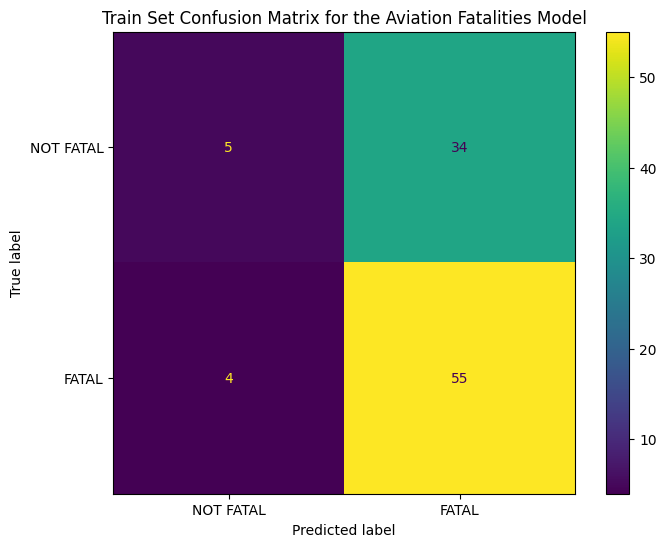

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_train, ((model.predict(X_train, verbose=0))>0.5)), display_labels=['NOT FATAL', 'FATAL'])

# set the plot title using the axes object
ax.set(title='Train Set Confusion Matrix for the Aviation Fatalities Model')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

In [67]:
score, acc = model.evaluate(X_train, y_train,
                            batch_size=10)
print('Train accuracy:', acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6122
Train accuracy: 0.6122449040412903


6 False Negatives, 8 False Positives.

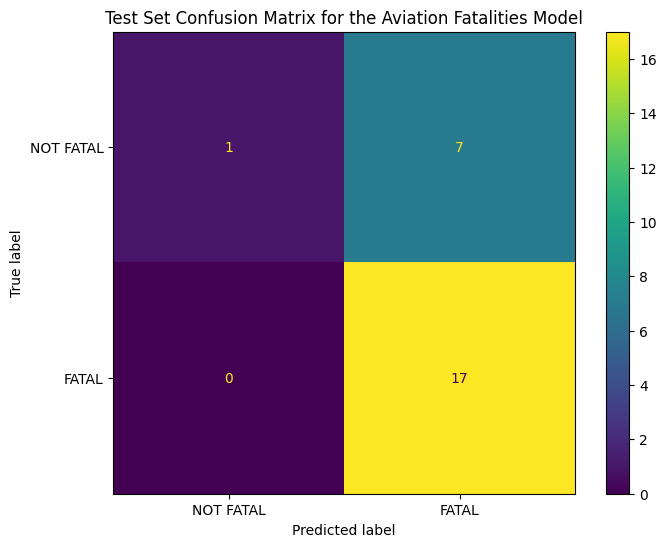

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, ((model.predict(X_test, verbose=0))>0.5)), display_labels=['NOT FATAL', 'FATAL'])

# set the plot title using the axes object
ax.set(title='Test Set Confusion Matrix for the Aviation Fatalities Model')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

1 False Negative and 3 False Positives, very good result.

In [69]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=10)
print('Test accuracy:', acc)

3/3 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.7200
Test accuracy: 0.7200000286102295


84% accuracy on unseen data (test set).

## Smote

In [103]:
model_smote = keras.Sequential(
    [
        keras.layers.Dense(units=20, activation="relu", input_shape=(X_train_resampled.shape[-1],) ),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=30, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=30, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(units=20, activation="relu"),
        # the output layer, with a single neuron
        # keras.layers.Dense(units=2, activation="sigmoid"),
        keras.layers.Dense(units=1, activation="sigmoid"),
     
    ]
)

In [104]:
learning_rate = 0.0001

model_smote.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              # metrics=keras.metrics.AUC()
              # metrics=[f1_m]
              metrics=['accuracy']
             )

In [105]:
history_smote = model_smote.fit(X_train_resampled, y_train_resampled, 
          epochs=100,
          batch_size=16, 
          validation_data=(X_test, y_test),
          verbose=0,
          # add in our early stopping callback
          callbacks=[early_stopping],
        )


In [106]:

logs_smote = pd.DataFrame(history_smote.history)
logs_smote


,loss,accuracy,val_loss,val_accuracy
0,0.693602,0.500000,0.701029,0.48
1,0.708786,0.500000,0.697642,0.48
2,0.700535,0.516949,0.694465,0.52
3,0.694954,0.483051,0.690887,0.56
4,0.692789,0.466102,0.689764,0.56
...,...,...,...,...
95,0.582168,0.720339,0.581389,0.72
96,0.599461,0.720339,0.579019,0.72
97,0.570409,0.762712,0.575572,0.72
98,0.578453,0.822034,0.572915,0.72


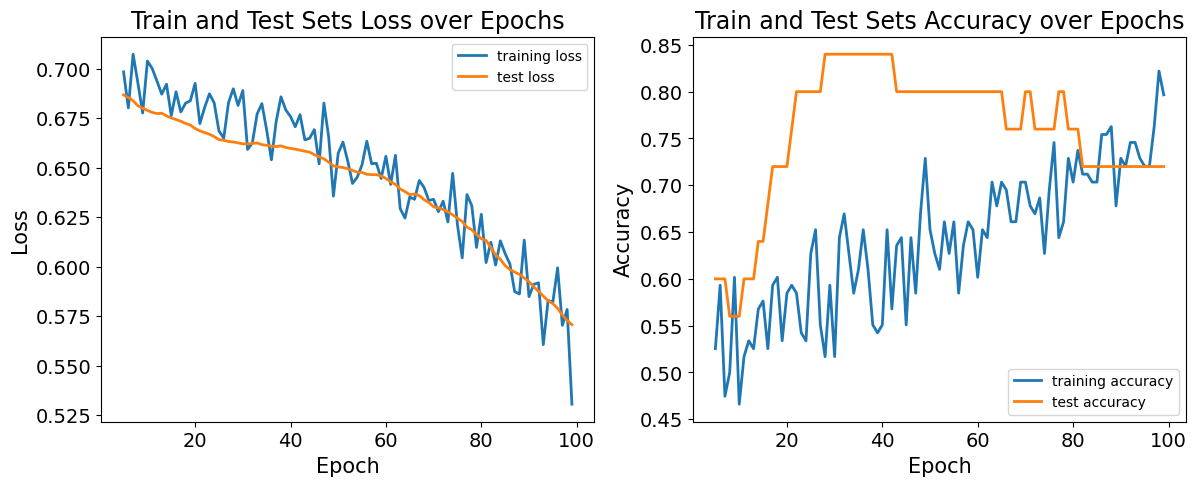

In [107]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("Train and Test Sets Loss over Epochs", fontsize=17)
plt.plot(logs_smote.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs_smote.loc[5:,"val_loss"], lw=2, label='test loss')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Train and Test Sets Accuracy over Epochs", fontsize=17)
plt.plot(logs_smote.loc[5:, logs_smote.columns[1]], lw=2, label='training accuracy')
plt.plot(logs_smote.loc[5:, logs_smote.columns[3]], lw=2, label='test accuracy')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right')
plt.show()

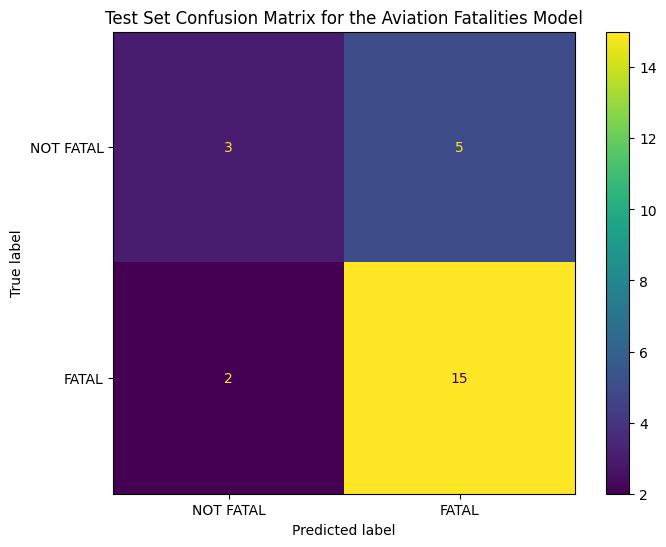

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, ((model_smote.predict(X_test, verbose=0))>0.5)), display_labels=['NOT FATAL', 'FATAL'])

# set the plot title using the axes object
ax.set(title='Test Set Confusion Matrix for the Aviation Fatalities Model')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

In [109]:
score, acc = model_smote.evaluate(X_test, y_test,
                            batch_size=10)
print('Test accuracy:', acc)

3/3 [==============================] - 0s 20ms/step - loss: 0.5707 - accuracy: 0.7200
Test accuracy: 0.7200000286102295


## Analysis of predictions

### Train set

In [ ]:
scaler2 = MinMaxScaler()

X2 = scaler2.fit_transform(X)

In [ ]:
temp_df = X.loc[123:, :]
temp_df.loc[123, 'prediction'] = 0.6264388
temp_df.loc[124, 'prediction'] = 0.524703


In [ ]:
temp_df.to_csv('spejimai.csv', index=False)

In [ ]:
X['prediction'] = (model.predict(X2, verbose=0))

In [ ]:
mask = (X['FLIGHT PHASE_descent'] == 1) \
& (X['IMC/VMC_vmc'] == 0) \
& (X['DAY/NIGHT_night'] == 0) \
& (X['skills deficiency_skills deficiency'] == 1) \
& (X['manual Handling_no manual handling'] == 0) \
& (X[' Ineffective Monitoring _no ineffective monitoring'] == 0) \
& (X['Procedural non compliance_procedural non compliance'] == 1) \
& (X[' innapropiate crew response _no inappropiate crew response'] == 0) \
& (X['Plan Continuation Bias_plan continuation bias'] == 1)

In [ ]:
X[mask]

,AIRCRAFT DAMAGE,YEAR,MONTH,DAY,CAUSE_cluster,HUMAN FACTOR_cluster,ye_antonov,ye_as332,ye_atr,ye_augusta,...,Distraction_no distraction,Stress_stress,Malicious Interference_no malicious interference,status awareness_status awareness,Pre Flight Data Input Error_pre flight data input error,Flight / Cabin Crew Co-operation_no flight / cabin crew co-operation,Pressure altimeter setting error_pressure altimeter setting error,Pilot Startle Response_pilot startle response,Flight Crew / Ground Crew Co-operation_no flight crew / ground crew co-operation,prediction
21,1.0,2008.0,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.590411
64,1.0,2019.0,12.0,26.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.591628
66,1.0,2013.0,8.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.561041


In [ ]:
X[mask].to_csv('zutis_tiketina.csv', index=False)

In [ ]:
mask2 = (X['FLIGHT PHASE_descent'] == 0) \
& (X['IMC/VMC_vmc'] == 1) \
& (X['skills deficiency_skills deficiency'] == 0) \
& (X['manual Handling_no manual handling'] == 1) \
& (X[' Ineffective Monitoring _no ineffective monitoring'] == 1) \
& (X['Procedural non compliance_procedural non compliance'] == 0) \
& (X[' innapropiate crew response _no inappropiate crew response'] == 1)

In [ ]:
X[mask2]

,AIRCRAFT DAMAGE,YEAR,MONTH,DAY,CAUSE_cluster,HUMAN FACTOR_cluster,ye_antonov,ye_as332,ye_atr,ye_augusta,...,Distraction_no distraction,Stress_stress,Malicious Interference_no malicious interference,status awareness_status awareness,Pre Flight Data Input Error_pre flight data input error,Flight / Cabin Crew Co-operation_no flight / cabin crew co-operation,Pressure altimeter setting error_pressure altimeter setting error,Pilot Startle Response_pilot startle response,Flight Crew / Ground Crew Co-operation_no flight crew / ground crew co-operation,prediction
93,1.0,2013.0,8.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.460820
117,0.0,2018.0,11.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.414091


In [ ]:
X[(mask) | (mask2)].to_csv('zuties_tikimybes_pagal_kriterijus.csv', index=False)

In [ ]:
X = X.append({
    'FLIGHT PHASE_descent': 0,
    'IMC/VMC_vmc': 0,
    'DAY/NIGHT_night': 1,
'skills deficiency_skills deficiency': 0,
'manual Handling_no manual handling': 1,
' Ineffective Monitoring _no ineffective monitoring': 1,
'Procedural non compliance_procedural non compliance': 0,
' innapropiate crew response _no inappropiate crew response': 1,
'Plan Continuation Bias_plan continuation bias': 0,
    }, ignore_index = True)

In [ ]:
X = X.fillna(X.median())

In [ ]:
model.predict(scaler2.transform(np.asarray(X.drop(columns='prediction').iloc[-1].values).astype('float32').reshape(1, -1)))

1/1 [==============================] - 0s 37ms/step


array([[0.6264388]], dtype=float32)

In [ ]:
X = X.append({
    'FLIGHT PHASE_descent': 1,
    'IMC/VMC_vmc': 1,
    'DAY/NIGHT_night': 0,
'skills deficiency_skills deficiency': 1,
'manual Handling_no manual handling': 0,
' Ineffective Monitoring _no ineffective monitoring': 0,
'Procedural non compliance_procedural non compliance': 1,
' innapropiate crew response _no inappropiate crew response': 0,
'Plan Continuation Bias_plan continuation bias': 1,
    }, ignore_index = True)

In [ ]:
X = X.fillna(X.median())

In [ ]:
model.predict(scaler2.transform(np.asarray(X.drop(columns='prediction').iloc[-1].values).astype('float32').reshape(1, -1)))


1/1 [==============================] - 0s 34ms/step


array([[0.524703]], dtype=float32)

In [ ]:
X.tail(2)

,AIRCRAFT DAMAGE,YEAR,MONTH,DAY,CAUSE_cluster,HUMAN FACTOR_cluster,ye_antonov,ye_as332,ye_atr,ye_augusta,...,Distraction_no distraction,Stress_stress,Malicious Interference_no malicious interference,status awareness_status awareness,Pre Flight Data Input Error_pre flight data input error,Flight / Cabin Crew Co-operation_no flight / cabin crew co-operation,Pressure altimeter setting error_pressure altimeter setting error,Pilot Startle Response_pilot startle response,Flight Crew / Ground Crew Co-operation_no flight crew / ground crew co-operation,prediction
123,1.0,2012.0,7.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
124,1.0,2012.0,7.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
df.columns

Index(['ye', 'FLIGHT PHASE', 'IMC/VMC', 'PAX/CARGO', 'DAY/NIGHT',
       'FATAL/NOTFATAL', 'AIRCRAFT DAMAGE', 'skills deficiency',
       'manual Handling', ' Ineffective Monitoring ', 'Fatigue',
       'Procedural non compliance', 'Pilot Medical Fitness', 'Violation',
       'Data use error', 'Inappropriate ATC Communication',
       ' innapropiate crew response ', 'Plan Continuation Bias',
       'Dual Sidestick Input', 'spatial Disorientation', 'Authority Gradient',
       'Distraction', 'Stress', 'Malicious Interference', 'status awareness',
       'Pre Flight Data Input Error', 'Flight / Cabin Crew Co-operation',
       'Pressure altimeter setting error', 'Pilot Startle Response',
       'Flight Crew / Ground Crew Co-operation', 'YEAR', 'MONTH', 'DAY',
       'CAUSE_cluster', 'HUMAN FACTOR_cluster'],
      dtype='object')

In [ ]:
df['Plan Continuation Bias']

1      no plan continuation bias
3      no plan continuation bias
4      no plan continuation bias
5      no plan continuation bias
6      no plan continuation bias
                 ...            
123    no plan continuation bias
124    no plan continuation bias
125    no plan continuation bias
126    no plan continuation bias
127    no plan continuation bias
Name: Plan Continuation Bias, Length: 123, dtype: object

In [ ]:
X['skills deficiency_skills deficiency']

KeyError: ignored

In [ ]:
X.columns

Index(['AIRCRAFT DAMAGE', 'YEAR', 'MONTH', 'DAY', 'CAUSE_cluster',
       'HUMAN FACTOR_cluster', 'ye_antonov', 'ye_as332', 'ye_atr',
       'ye_augusta', 'ye_beech', 'ye_boeing', 'ye_bombardier', 'ye_cessa',
       'ye_cessna', 'ye_crossair', 'ye_dassault', 'ye_dornier', 'ye_douglas',
       'ye_embraer', 'ye_eurocopter', 'ye_gulfstream', 'ye_hawker', 'ye_let',
       'ye_mcdonnell', 'ye_md', 'ye_mystere', 'ye_other', 'ye_peace',
       'ye_piper', 'FLIGHT PHASE_ descent', 'FLIGHT PHASE_approach',
       'FLIGHT PHASE_climb', 'FLIGHT PHASE_cruise', 'FLIGHT PHASE_descent',
       'FLIGHT PHASE_landing', 'FLIGHT PHASE_manoeuvring',
       'FLIGHT PHASE_missed approach', 'FLIGHT PHASE_take off', 'IMC/VMC_vmc',
       'PAX/CARGO_cargo', 'PAX/CARGO_military/state', 'PAX/CARGO_pax flight',
       'PAX/CARGO_private', 'DAY/NIGHT_night',
       'skills deficiency_skills deficiency',
       'manual Handling_no manual handling',
       ' Ineffective Monitoring _no ineffective monitoring',
     

In [ ]:
((model.predict(X_train, verbose=0))>0.5)

array([[ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [ ]:
((model.predict(X_test, verbose=0))>0.5)


array([[ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True]])

### Feature Importance

In [ ]:
pip install shap

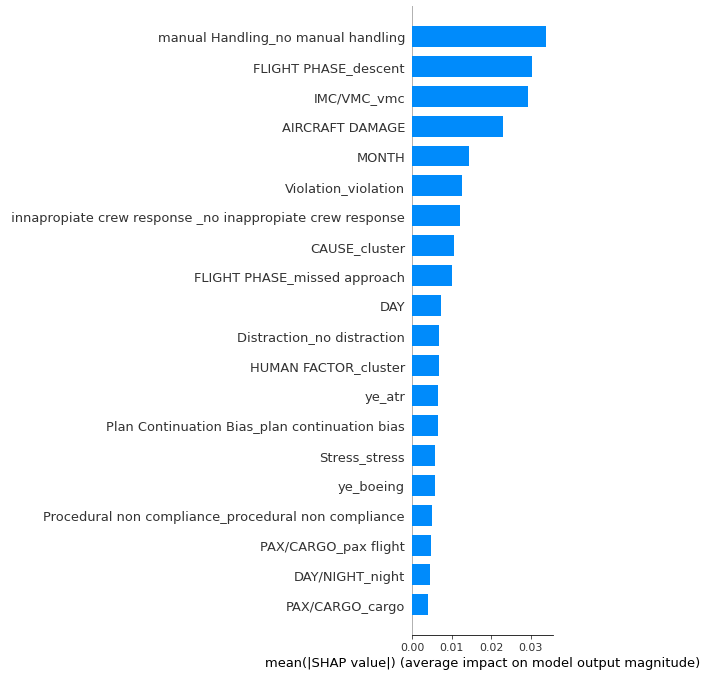

In [ ]:
import shap
# compute SHAP values
shap.initjs()
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X.columns)

Most Important Features are manual handling, FLIGHT PHASE, IMC/VMC, AIRCRAFT DAMAGE and VIOLATION.

### Save Model

In [ ]:
model.save("my_model")

In [ ]:
!tar cf model.tar my_model

### Load Model

In [ ]:
reconstructed_model = keras.models.load_model("my_model")

### Model Layers:

In [ ]:
from IPython.display import SVG, display

In [ ]:
SVG(filename='nn.svg')

#### NOT TO SCALE MODEL VERSION

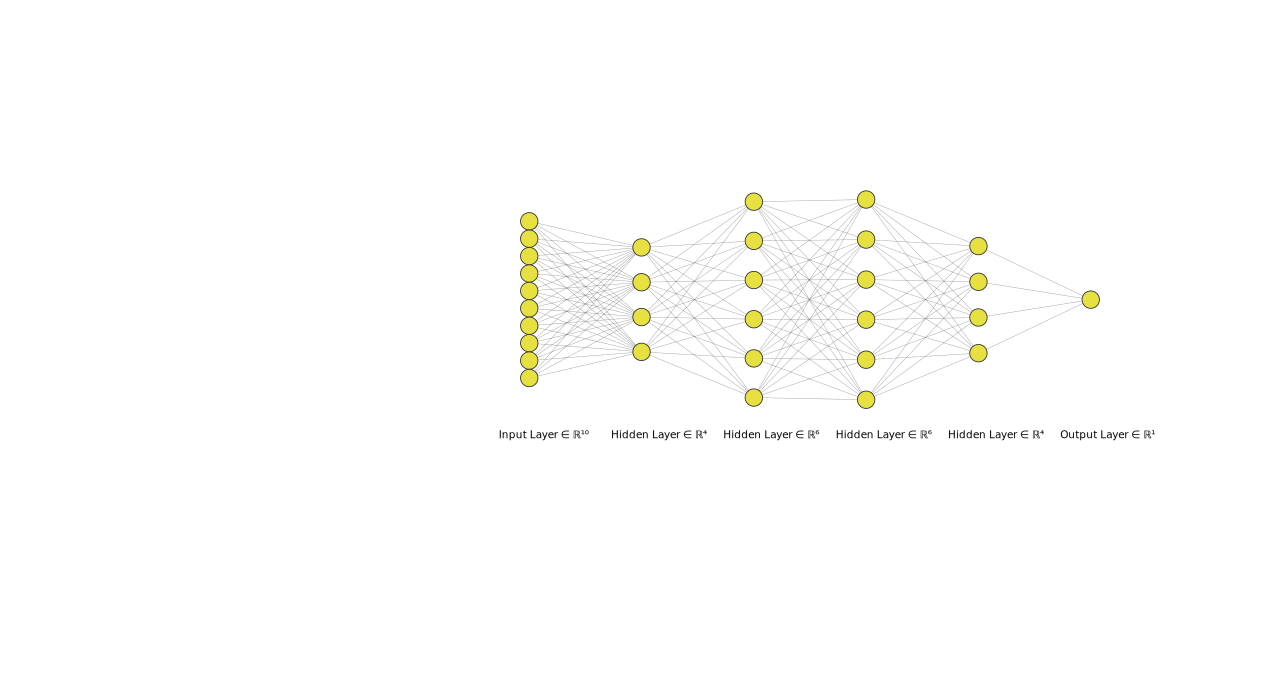

In [ ]:
SVG(filename='nn (1).svg')

#### Analysis

In [ ]:
y_pred_values = model.predict(X_train.tolist() + X_test.tolist())
y_pred = (y_pred_values > 0.5)

4/4 [==============================] - 0s 3ms/step


In [ ]:
df['predicted'] = y_pred
df['predicted'] = df['predicted'].astype(int)
df['prediction_value'] = y_pred_values

In [ ]:
df[df['predicted'] != df['FATAL/NOTFATAL']].mode().head(1)

,ye,FLIGHT PHASE,IMC/VMC,PAX/CARGO,DAY/NIGHT,FATAL/NOTFATAL,AIRCRAFT DAMAGE,skills deficiency,manual Handling,Ineffective Monitoring,...,Pressure altimeter setting error,Pilot Startle Response,Flight Crew / Ground Crew Co-operation,YEAR,MONTH,DAY,CAUSE_cluster,HUMAN FACTOR_cluster,predicted,prediction_value
0,airbus,descent,imc,pax flight,day,0.0,1.0,no skills deficiency,no manual handling,ineffective monitoring,...,no pressure altimeter setting error,no pilot startle response,no flight crew / ground crew co-operation,2017.0,11.0,24.0,0.0,0.0,1.0,0.407325


## Comparison and Results

84% accuracy for NN model, it means it is capable of finding trends within data and achieving significant results as 65% accuracy would be achieved by only predicting FATAL class, as it contains 65% of the data points.

## Conclusion